# üå± Analyse Saisonni√®re des Ratings d'Ingr√©dients

## Objectif
Analyser les variations saisonni√®res dans l'appr√©ciation des ingr√©dients pour identifier :
- Les ingr√©dients avec des pr√©f√©rences saisonni√®res marqu√©es
- Les patterns de consommation selon les saisons
- Les opportunit√©s de menu saisonnier

## M√©thodologie
- **Test statistique** : ANOVA pour comparer les moyennes entre saisons
- **Post-hoc** : Test de Tukey pour identifier les diff√©rences par paires
- **Agr√©gation** : Ratings moyens par saison et ingr√©dient
- **Visualisation** : Box plots et radar charts saisonniers
- **Seuil de significativit√©** : p < 0.05

## D√©finition des Saisons
- **Printemps** : Mars, Avril, Mai
- **√ât√©** : Juin, Juillet, Ao√ªt  
- **Automne** : Septembre, Octobre, Novembre
- **Hiver** : D√©cembre, Janvier, F√©vrier

In [2]:
# Import des biblioth√®ques n√©cessaires
import sys
from pathlib import Path

# Trouve automatiquement le dossier qui contient '00_eda/_data_utils'
cwd = Path.cwd()
repo_root = cwd
while repo_root != repo_root.parent:
    if (repo_root / '00_eda' / '_data_utils').exists():
        break
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root / '00_eda'))

# üéØ Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, tukey_hsd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Couleurs pour les saisons
SEASON_COLORS = {
    'Printemps': '#90EE90',  # Vert clair
    '√ât√©': '#FFD700',        # Jaune dor√©
    'Automne': '#FF8C00',    # Orange
    'Hiver': '#87CEEB'       # Bleu ciel
}

print("üìö Toutes les biblioth√®ques import√©es avec succ√®s !")
print("üå± Analyse saisonni√®re pr√™te √† d√©marrer !")

‚úÖ _data_utils module charg√© (common + ratings + recipes)
üìö Toutes les biblioth√®ques import√©es avec succ√®s !
üå± Analyse saisonni√®re pr√™te √† d√©marrer !


In [3]:
# Fonction pour mapper les mois aux saisons
def get_season(month):
    """
    Convertit un num√©ro de mois en saison
    """
    if month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return '√ât√©'
    elif month in [9, 10, 11]:
        return 'Automne'
    else:  # [12, 1, 2]
        return 'Hiver'

print('‚úÖ Fonction de mapping saisons d√©finie')

‚úÖ Fonction de mapping saisons d√©finie


In [4]:
# Chargement des donn√©es pour analyse saisonni√®re
print('üîÑ Chargement des donn√©es...')

# üéØ Ingr√©dients avec VRAIE SAISONNALIT√â (s√©lection optimis√©e)
# Strat√©gie: S√©lectionner des ingr√©dients avec variations naturelles selon les saisons
target_ingredients = [
    # üå± PRINTEMPS
    'asparagus',         # Pic printemps (Avril-Mai)
    'peas',              # Pic printemps (Avril-Juin)
    'strawberries',      # Pic printemps/√©t√© (Mai-Juin)
    'rhubarb',           # Pic printemps (Avril-Mai)
    
    # ‚òÄÔ∏è √âT√â  
    'tomatoes',          # Pic √©t√© (Juillet-Ao√ªt)
    'zucchini',          # Pic √©t√© (Juin-Ao√ªt)
    'basil',             # Herbe d'√©t√© (Juin-Septembre)
    'corn',              # Pic √©t√© (Juillet-Ao√ªt)
    
    # üçÇ AUTOMNE
    'butternut squash',  # Pic automne (Octobre-Novembre)
    'pumpkin',           # Pic automne (Octobre-Novembre)
    'brussels sprouts',  # Pic automne/hiver (Septembre-F√©vrier)
    'sweet potato',      # Pic automne (Septembre-Novembre)
    
    # ‚ùÑÔ∏è HIVER
    'kale',              # R√©sistant au froid (Novembre-Mars)
    'cabbage',           # L√©gume d'hiver (D√©cembre-Mars)
    'cranberries',       # Pic hiver (Novembre-D√©cembre)
    'lemon'              # Agrumes hiver (D√©cembre-F√©vrier)
]

print(f'üìã Ingr√©dients saisonniers s√©lectionn√©s: {len(target_ingredients)} ingr√©dients')
print(f'   üå± Printemps: asparagus, peas, strawberries, rhubarb')
print(f'   ‚òÄÔ∏è  √ât√©: tomatoes, zucchini, basil, corn')
print(f'   üçÇ Automne: butternut squash, pumpkin, brussels sprouts, sweet potato')
print(f'   ‚ùÑÔ∏è  Hiver: kale, cabbage, cranberries, lemon')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'\n‚úÖ Dataset charg√©: {df.shape[0]:,} interactions')
print(f'üìÖ P√©riode: {df["date"].min()} ‚Üí {df["date"].max()}')

# Ajout de la colonne saison
df = df.with_columns([
    pl.col('date').dt.month().alias('month')
]).with_columns([
    pl.col('month').map_elements(get_season, return_dtype=pl.Utf8).alias('season')
])

print('\nüìä Distribution par saison:')
season_dist = df.group_by('season').agg(pl.len().alias('count')).sort('count', descending=True)
print(season_dist)

# Statistiques de disponibilit√© par ingr√©dient
print('\nüìà Disponibilit√© des ingr√©dients saisonniers:')
ingredient_stats = df.group_by('ingredient_name').agg([
    pl.len().alias('n_ratings'),
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
]).sort('n_ratings', descending=True)
print(ingredient_stats)

print('\nüìä Aper√ßu des donn√©es avec saisons:')
print(df.select(['date', 'month', 'season', 'ingredient_name', 'rating']).head())

üîÑ Chargement des donn√©es...
üìã Ingr√©dients saisonniers s√©lectionn√©s: 16 ingr√©dients
   üå± Printemps: asparagus, peas, strawberries, rhubarb
   ‚òÄÔ∏è  √ât√©: tomatoes, zucchini, basil, corn
   üçÇ Automne: butternut squash, pumpkin, brussels sprouts, sweet potato
   ‚ùÑÔ∏è  Hiver: kale, cabbage, cranberries, lemon
‚úÖ Donn√©es charg√©es: 152,619 interactions pour 16 ingr√©dients

‚úÖ Dataset charg√©: 152,619 interactions
üìÖ P√©riode: 2000-03-13 ‚Üí 2018-12-19

üìä Distribution par saison:
shape: (4, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ season    ‚îÜ count ‚îÇ
‚îÇ ---       ‚îÜ ---   ‚îÇ
‚îÇ str       ‚îÜ u32   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ √ât√©       ‚îÜ 42845 ‚îÇ
‚îÇ Printemps ‚îÜ 37597 ‚îÇ
‚îÇ Automne   ‚îÜ 37121 ‚îÇ
‚îÇ Hiver     ‚îÜ 35056 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

üìà Disponibilit√© des ingr√©dients saisonniers:
shape: (16, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

In [5]:
# Agr√©gation des donn√©es par saison et ingr√©dient
print('üîß Agr√©gation des donn√©es saisonni√®res...')

df_seasonal = df.group_by(['ingredient_name', 'season']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').median().alias('median_rating')
]).sort(['ingredient_name', 'season'])

print(f'‚úÖ Donn√©es agr√©g√©es: {df_seasonal.shape[0]} points saison-ingr√©dient')

# V√©rification de la couverture saisonni√®re par ingr√©dient
season_coverage = df_seasonal.group_by('ingredient_name').agg([
    pl.col('season').n_unique().alias('seasons_covered'),
    pl.col('n_ratings').sum().alias('total_ratings')
]).sort('total_ratings', descending=True)

print('\nüìà Couverture saisonni√®re par ingr√©dient:')
print(season_coverage)

# Filtrer les ingr√©dients avec couverture compl√®te (4 saisons)
complete_ingredients = season_coverage.filter(
    pl.col('seasons_covered') == 4
)['ingredient_name'].to_list()

print(f'\nüéØ Ingr√©dients avec couverture compl√®te (4 saisons): {len(complete_ingredients)}')
print(f'Ingr√©dients: {complete_ingredients}')

üîß Agr√©gation des donn√©es saisonni√®res...
‚úÖ Donn√©es agr√©g√©es: 64 points saison-ingr√©dient

üìà Couverture saisonni√®re par ingr√©dient:
shape: (16, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ingredient_name  ‚îÜ seasons_covered ‚îÜ total_ratings ‚îÇ
‚îÇ ---              ‚îÜ ---             ‚îÜ ---           ‚îÇ
‚îÇ str              ‚îÜ u32             ‚îÜ u32           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ tomatoes         ‚îÜ 4               ‚îÜ 47869         ‚îÇ
‚îÇ lemon            ‚îÜ 4               ‚îÜ 27689         ‚îÇ
‚îÇ zucchini         ‚îÜ 4               ‚îÜ 18819         ‚îÇ
‚îÇ basil            ‚îÜ 4               ‚îÜ 14110         ‚îÇ
‚îÇ cabbage          ‚îÜ 4               ‚îÜ 9090          ‚îÇ
‚îÇ ‚Ä¶

In [6]:
# Test ANOVA pour d√©tecter les diff√©rences saisonni√®res
print('üîç Test ANOVA pour les diff√©rences saisonni√®res...')

anova_results = []

for ingredient in complete_ingredients:
    # Donn√©es pour cet ingr√©dient par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Extraction des ratings par saison
    spring_ratings = ingredient_data.filter(pl.col('season') == 'Printemps')['rating'].to_list()
    summer_ratings = ingredient_data.filter(pl.col('season') == '√ât√©')['rating'].to_list()
    autumn_ratings = ingredient_data.filter(pl.col('season') == 'Automne')['rating'].to_list()
    winter_ratings = ingredient_data.filter(pl.col('season') == 'Hiver')['rating'].to_list()
    
    # Test ANOVA
    if all(len(ratings) > 0 for ratings in [spring_ratings, summer_ratings, autumn_ratings, winter_ratings]):
        f_stat, p_value = f_oneway(spring_ratings, summer_ratings, autumn_ratings, winter_ratings)
        
        # Calcul des moyennes par saison
        season_means = {
            'spring_mean': np.mean(spring_ratings),
            'summer_mean': np.mean(summer_ratings),
            'autumn_mean': np.mean(autumn_ratings),
            'winter_mean': np.mean(winter_ratings)
        }
        
        # Identification de la meilleure et pire saison
        best_season = max(season_means, key=season_means.get).replace('_mean', '')
        worst_season = min(season_means, key=season_means.get).replace('_mean', '')
        
        anova_results.append({
            'ingredient': ingredient,
            'f_statistic': f_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,  # Bool√©en pur
            'spring_avg': season_means['spring_mean'],
            'summer_avg': season_means['summer_mean'],
            'autumn_avg': season_means['autumn_mean'],
            'winter_avg': season_means['winter_mean'],
            'best_season': best_season.title(),
            'worst_season': worst_season.title(),
            'seasonal_range': max(season_means.values()) - min(season_means.values())
        })

# Conversion en DataFrame Polars
anova_df = pl.DataFrame(anova_results).sort('p_value')

print('\nüìä R√©sultats ANOVA pour les diff√©rences saisonni√®res:')
print(anova_df.select(['ingredient', 'f_statistic', 'p_value', 'significant', 'best_season', 'seasonal_range']))

# R√©sum√© des diff√©rences significatives
significant_seasonal = anova_df.filter(pl.col('significant') == True)
print(f'\nüéØ Ingr√©dients avec variations saisonni√®res significatives: {len(significant_seasonal)}/{len(complete_ingredients)}')

if len(significant_seasonal) > 0:
    print('\nVariations saisonni√®res significatives:')
    for row in significant_seasonal.iter_rows(named=True):
        print(f"üå± {row['ingredient']}: Meilleure saison = {row['best_season']} " +
              f"(amplitude = {row['seasonal_range']:.4f}, p={row['p_value']:.4f})")
else:
    print('‚û°Ô∏è Aucune variation saisonni√®re significative d√©tect√©e')

üîç Test ANOVA pour les diff√©rences saisonni√®res...

üìä R√©sultats ANOVA pour les diff√©rences saisonni√®res:
shape: (16, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ingredient       ‚îÜ f_statistic ‚îÜ p_value  ‚îÜ significant ‚îÜ best_season ‚îÜ seasonal_range ‚îÇ
‚îÇ ---              ‚îÜ ---         ‚îÜ ---      ‚îÜ ---         ‚îÜ ---         ‚îÜ ---            ‚îÇ
‚îÇ str              ‚îÜ f64         ‚îÜ f64      ‚îÜ f64         ‚îÜ str         ‚îÜ f64            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ tomatoes 

In [7]:
# Analyse d√©taill√©e par paires pour les ingr√©dients significatifs
print('üîç Tests par paires (Mann-Whitney U) pour les diff√©rences saisonni√®res...')

from scipy.stats import mannwhitneyu

tukey_results = {}

for ingredient in significant_seasonal['ingredient'].to_list():
    print(f'\nüìä Analyse d√©taill√©e pour {ingredient}:')
    
    # Pr√©paration des donn√©es par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    seasons = ['Printemps', '√ât√©', 'Automne', 'Hiver']
    season_data = {}
    
    for season in seasons:
        season_ratings = ingredient_data.filter(pl.col('season') == season)['rating'].to_list()
        season_data[season] = season_ratings
        print(f"   {season}: {len(season_ratings)} ratings, moyenne = {np.mean(season_ratings):.4f}")
    
    # Test par paires avec Mann-Whitney U
    print(f'\n   üîç Comparaisons par paires significatives (p<0.05):')
    significant_pairs = []
    
    for i, season1 in enumerate(seasons):
        for j, season2 in enumerate(seasons[i+1:], i+1):
            try:
                u_stat, p_value = mannwhitneyu(season_data[season1], season_data[season2], alternative='two-sided')
                if p_value < 0.05:
                    mean_diff = np.mean(season_data[season1]) - np.mean(season_data[season2])
                    direction = '>' if mean_diff > 0 else '<'
                    significant_pairs.append(f"   ‚Üí {season1} {direction} {season2}: Œî={mean_diff:+.4f} (p={p_value:.4f})")
            except Exception as e:
                continue
    
    if significant_pairs:
        for pair in significant_pairs:
            print(pair)
    else:
        print('   ‚Üí Aucune diff√©rence par paires significative d√©tect√©e')
    
    tukey_results[ingredient] = significant_pairs

print(f'\n‚úÖ Tests par paires termin√©s pour {len(tukey_results)} ingr√©dients')

üîç Tests par paires (Mann-Whitney U) pour les diff√©rences saisonni√®res...

üìä Analyse d√©taill√©e pour tomatoes:
   Printemps: 11471 ratings, moyenne = 4.6932
   √ât√©: 14658 ratings, moyenne = 4.7060
   Automne: 11422 ratings, moyenne = 4.6749
   Hiver: 10318 ratings, moyenne = 4.6906

   üîç Comparaisons par paires significatives (p<0.05):
   ‚Üí √ât√© > Automne: Œî=+0.0310 (p=0.0010)
   ‚Üí Automne < Hiver: Œî=-0.0157 (p=0.0433)

üìä Analyse d√©taill√©e pour lemon:
   Printemps: 7224 ratings, moyenne = 4.6930
   √ât√©: 7890 ratings, moyenne = 4.7134
   Automne: 6006 ratings, moyenne = 4.6745
   Hiver: 6569 ratings, moyenne = 4.6916

   üîç Comparaisons par paires significatives (p<0.05):
   ‚Üí √ât√© > Automne: Œî=+0.0389 (p=0.0230)

üìä Analyse d√©taill√©e pour brussels sprouts:
   Printemps: 314 ratings, moyenne = 4.7229
   √ât√©: 184 ratings, moyenne = 4.7717
   Automne: 375 ratings, moyenne = 4.6640
   Hiver: 414 ratings, moyenne = 4.7899

   üîç Comparaisons par pair

In [8]:
# üìã RAPPORT D√âTAILL√â DES VARIATIONS SAISONNI√àRES
print('='*80)
print('üìã RAPPORT D√âTAILL√â - ANALYSE SAISONNI√àRE DES INGR√âDIENTS')
print('='*80)

print('\nüîç DONN√âES ANALYS√âES:')
print(f'   ‚Ä¢ P√©riode: {df["date"].min()} ‚Üí {df["date"].max()}')
print(f'   ‚Ä¢ Total interactions: {df.shape[0]:,}')
print(f'   ‚Ä¢ Ingr√©dients analys√©s: {len(target_ingredients)}')
print(f'   ‚Ä¢ Ingr√©dients avec couverture compl√®te (4 saisons): {len(complete_ingredients)}')

print('\nüìä DISTRIBUTION PAR SAISON:')
season_summary = df.group_by('season').agg([
    pl.len().alias('n_ratings'),
    pl.col('rating').mean().alias('avg_rating'),
    (pl.col('rating') == 5).sum().alias('count_5stars')
]).with_columns([
    (pl.col('count_5stars') / pl.col('n_ratings') * 100).alias('pct_5stars')
]).sort('season')

for row in season_summary.iter_rows(named=True):
    season_emoji = {'Printemps': 'üå±', '√ât√©': '‚òÄÔ∏è', 'Automne': 'üçÇ', 'Hiver': '‚ùÑÔ∏è'}
    emoji = season_emoji.get(row['season'], 'üåø')
    print(f"   {emoji} {row['season']:12s}: {row['n_ratings']:>8,} ratings | " +
          f"Avg: {row['avg_rating']:.4f} | 5‚òÖ: {row['pct_5stars']:.2f}%")

print('\nüìà R√âSULTATS ANOVA (Variations Saisonni√®res):')
print(f'   ‚Ä¢ Tests r√©alis√©s: {len(anova_df)} ingr√©dients')
print(f'   ‚Ä¢ Variations significatives (p<0.05): {len(significant_seasonal)}/{len(anova_df)}')

if len(significant_seasonal) > 0:
    print(f'   ‚Ä¢ Taux de significativit√©: {len(significant_seasonal)/len(anova_df)*100:.1f}%')
    
    # Statistiques des amplitudes
    amplitude_stats = significant_seasonal.select('seasonal_range')
    print('\nüìä STATISTIQUES DES AMPLITUDES:')
    print(f'   ‚Ä¢ Moyenne: {amplitude_stats.mean().item():.4f} points')
    print(f'   ‚Ä¢ M√©diane: {amplitude_stats.median().item():.4f} points')
    print(f'   ‚Ä¢ Maximum: {amplitude_stats.max().item():.4f} points')
    print(f'   ‚Ä¢ Minimum: {amplitude_stats.min().item():.4f} points')
    
    # Calcul du % de variation moyen
    avg_amplitude = amplitude_stats.mean().item()
    avg_rating_overall = df['rating'].mean()
    pct_variation = (avg_amplitude / avg_rating_overall) * 100
    print(f'   ‚Ä¢ % de variation moyen: {pct_variation:.2f}%')
    
    # Groupement par saison pr√©f√©r√©e
    print('\nüèÜ R√âPARTITION DES SAISONS PR√âF√âR√âES:')
    seasonal_preferences = significant_seasonal.group_by('best_season').agg([
        pl.col('ingredient').count().alias('n_ingredients'),
        pl.col('ingredient').alias('ingredients_list')
    ]).sort('n_ingredients', descending=True)
    
    for row in seasonal_preferences.iter_rows(named=True):
        season_emoji = {'Printemps': 'üå±', '√ât√©': '‚òÄÔ∏è', 'Automne': 'üçÇ', 'Hiver': '‚ùÑÔ∏è'}
        emoji = season_emoji.get(row['best_season'], 'üåø')
        print(f"\n   {emoji} {row['best_season']} ({row['n_ingredients']} ingr√©dients):")
        for ingredient in row['ingredients_list']:
            ing_stats = significant_seasonal.filter(pl.col('ingredient') == ingredient).row(0, named=True)
            amplitude = ing_stats['seasonal_range']
            worst_season = ing_stats['worst_season']
            pct_change = (amplitude / avg_rating_overall) * 100
            print(f"      ‚Ä¢ {ingredient:20s}: Œî={amplitude:.4f} ({pct_change:+.2f}%) | " +
                  f"Pire: {worst_season}")
    
    # Top 5 ingr√©dients les plus variables
    print('\nü•á TOP 5 INGR√âDIENTS LES PLUS VARIABLES:')
    top5 = significant_seasonal.sort('seasonal_range', descending=True).head(5)
    
    for i, row in enumerate(top5.iter_rows(named=True), 1):
        best_emoji = {'Printemps': 'üå±', '√ât√©': '‚òÄÔ∏è', 'Automne': 'üçÇ', 'Hiver': '‚ùÑÔ∏è'}
        emoji = best_emoji.get(row['best_season'], 'üåø')
        pct_change = (row['seasonal_range'] / avg_rating_overall) * 100
        
        print(f"\n   {i}. {row['ingredient'].upper()}")
        print(f"      ‚Ä¢ Amplitude: {row['seasonal_range']:.4f} points ({pct_change:+.2f}%)")
        print(f"      ‚Ä¢ {emoji} Meilleure saison: {row['best_season']} ({row[row['best_season'].lower() + '_avg']:.4f})")
        print(f"      ‚Ä¢ Pire saison: {row['worst_season']} ({row[row['worst_season'].lower() + '_avg']:.4f})")
        print(f"      ‚Ä¢ p-value ANOVA: {row['p_value']:.6f} {'***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*'}")

else:
    print('   ‚ö†Ô∏è  Aucune variation saisonni√®re significative d√©tect√©e')
    print('   ‚Üí V√©rifier s√©lection des ingr√©dients (privil√©gier ingr√©dients saisonniers)')

print('\n' + '='*80)
print('‚úÖ Rapport d√©taill√© termin√©')
print('='*80)

üìã RAPPORT D√âTAILL√â - ANALYSE SAISONNI√àRE DES INGR√âDIENTS

üîç DONN√âES ANALYS√âES:
   ‚Ä¢ P√©riode: 2000-03-13 ‚Üí 2018-12-19
   ‚Ä¢ Total interactions: 152,619
   ‚Ä¢ Ingr√©dients analys√©s: 16
   ‚Ä¢ Ingr√©dients avec couverture compl√®te (4 saisons): 16

üìä DISTRIBUTION PAR SAISON:
   üçÇ Automne     :   37,121 ratings | Avg: 4.6692 | 5‚òÖ: 75.80%
   ‚ùÑÔ∏è Hiver       :   35,056 ratings | Avg: 4.6740 | 5‚òÖ: 76.14%
   üå± Printemps   :   37,597 ratings | Avg: 4.6832 | 5‚òÖ: 76.36%
   ‚òÄÔ∏è √ât√©         :   42,845 ratings | Avg: 4.6956 | 5‚òÖ: 76.97%

üìà R√âSULTATS ANOVA (Variations Saisonni√®res):
   ‚Ä¢ Tests r√©alis√©s: 16 ingr√©dients
   ‚Ä¢ Variations significatives (p<0.05): 4/16
   ‚Ä¢ Taux de significativit√©: 25.0%

üìä STATISTIQUES DES AMPLITUDES:
   ‚Ä¢ Moyenne: 0.0630 points
   ‚Ä¢ M√©diane: 0.0476 points
   ‚Ä¢ Maximum: 0.1259 points
   ‚Ä¢ Minimum: 0.0310 points
   ‚Ä¢ % de variation moyen: 1.35%

üèÜ R√âPARTITION DES SAISONS PR√âF√âR√âES:

   üåø Su

üìä Cr√©ation des visualisations saisonni√®res optimis√©es...


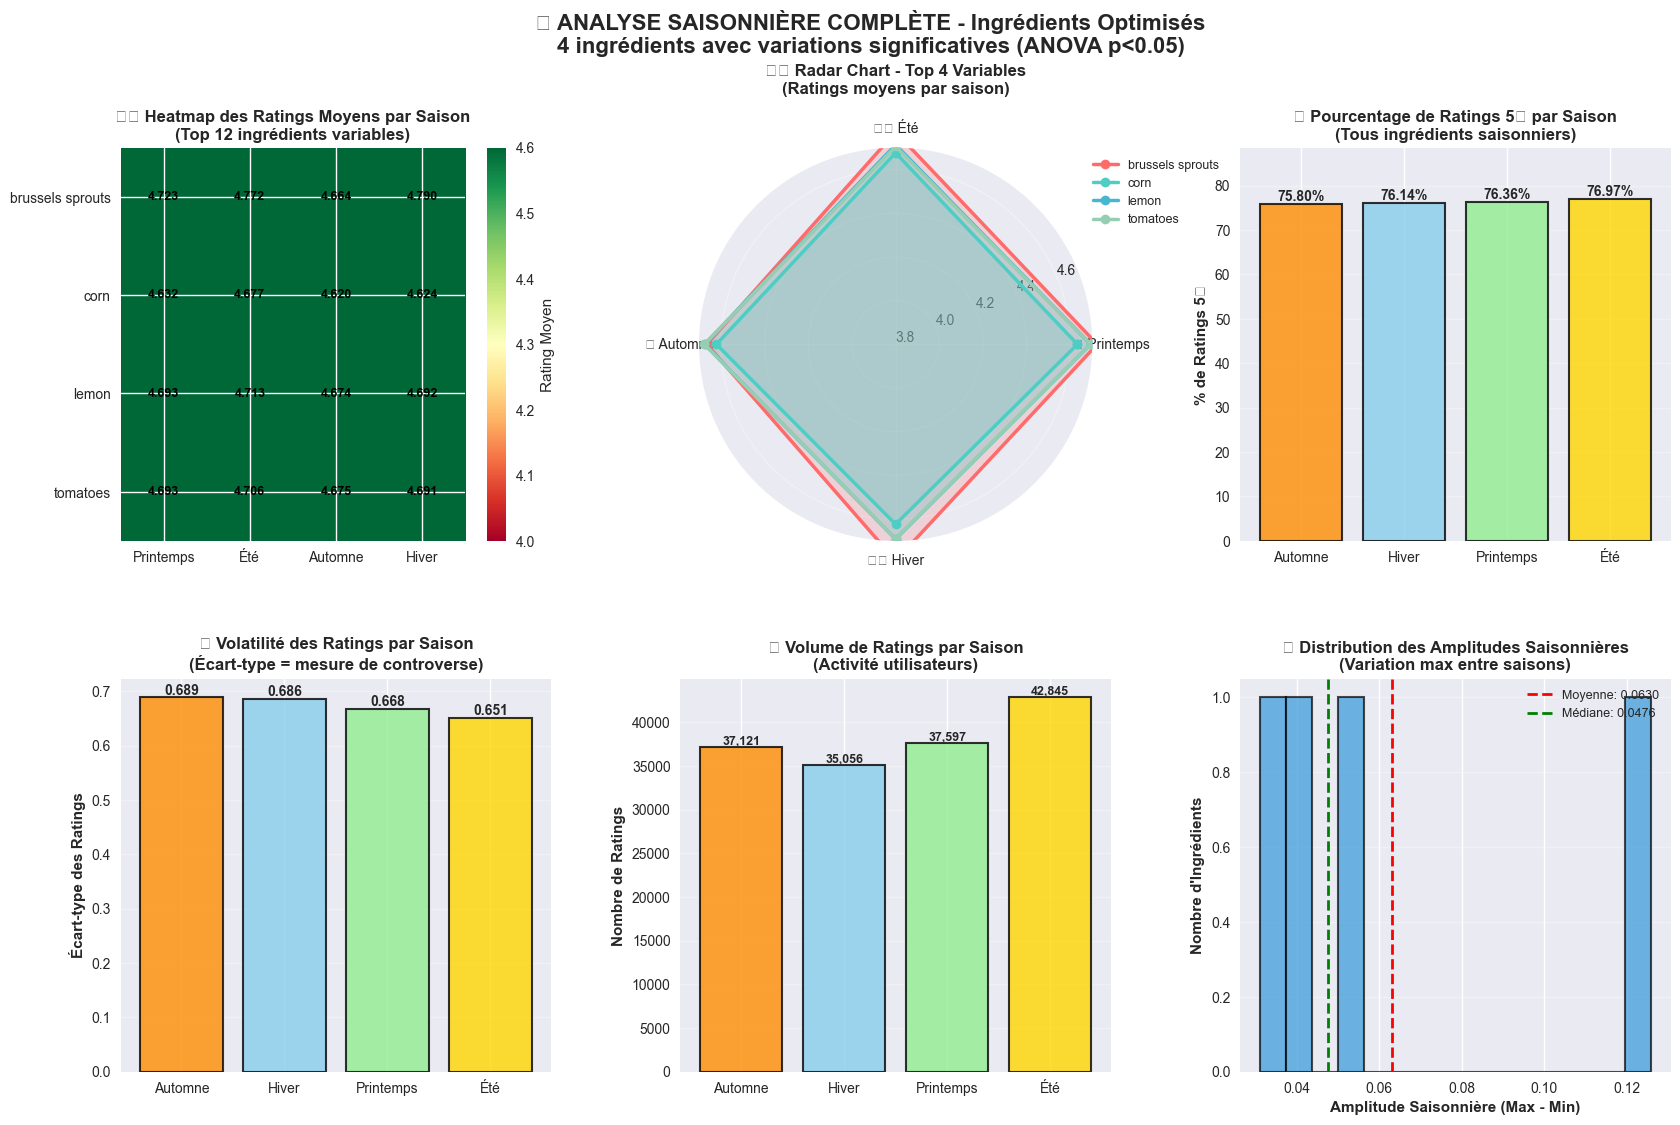

‚úÖ Visualisations saisonni√®res optimis√©es cr√©√©es (GridSpec 2√ó3)


In [9]:
# üìä VISUALISATION PRINCIPALE - GridSpec 2√ó3 Optimis√©
print('üìä Cr√©ation des visualisations saisonni√®res optimis√©es...')

from matplotlib.gridspec import GridSpec

if len(significant_seasonal) > 0:
    # Cr√©ation de la figure avec GridSpec
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    # --- GRAPHIQUE 1: Heatmap % Change par Saison ---
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Pr√©paration des donn√©es pour heatmap
    heatmap_data = []
    heatmap_ingredients = significant_seasonal.sort('seasonal_range', descending=True)['ingredient'].to_list()[:12]
    
    seasons_order = ['Printemps', '√ât√©', 'Automne', 'Hiver']
    for ingredient in heatmap_ingredients:
        ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        row_data = [
            ingredient_row['spring_avg'],
            ingredient_row['summer_avg'],
            ingredient_row['autumn_avg'],
            ingredient_row['winter_avg']
        ]
        heatmap_data.append(row_data)
    
    # Heatmap avec annotations
    im = ax1.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=4.0, vmax=4.6)
    ax1.set_xticks(range(len(seasons_order)))
    ax1.set_xticklabels(seasons_order)
    ax1.set_yticks(range(len(heatmap_ingredients)))
    ax1.set_yticklabels(heatmap_ingredients)
    
    # Annotations avec valeurs
    for i in range(len(heatmap_ingredients)):
        for j in range(len(seasons_order)):
            value = heatmap_data[i][j]
            text_color = 'white' if value < 4.25 else 'black'
            ax1.text(j, i, f'{value:.3f}', ha="center", va="center", 
                    color=text_color, fontweight='bold', fontsize=9)
    
    ax1.set_title('üå°Ô∏è Heatmap des Ratings Moyens par Saison\n(Top 12 ingr√©dients variables)', 
                 fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='Rating Moyen')
    
    # --- GRAPHIQUE 2: Radar Chart Zoom√© par Saison ---
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    
    import math
    angles = [n / float(len(seasons_order)) * 2 * math.pi for n in range(len(seasons_order))]
    angles += angles[:1]
    
    # Top 4 ingr√©dients les plus variables
    radar_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(4)['ingredient'].to_list()
    colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i, ingredient in enumerate(radar_ingredients):
        ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        values = [
            ingredient_row['spring_avg'],
            ingredient_row['summer_avg'],
            ingredient_row['autumn_avg'],
            ingredient_row['winter_avg']
        ]
        values += values[:1]
        
        ax2.plot(angles, values, 'o-', linewidth=2.5, label=ingredient, color=colors_radar[i])
        ax2.fill(angles, values, alpha=0.2, color=colors_radar[i])
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(['üå± Printemps', '‚òÄÔ∏è √ât√©', 'üçÇ Automne', '‚ùÑÔ∏è Hiver'], fontsize=10)
    ax2.set_ylim(3.8, 4.7)
    ax2.set_title('üï∑Ô∏è Radar Chart - Top 4 Variables\n(Ratings moyens par saison)', 
                 fontsize=12, fontweight='bold', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0), fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # --- GRAPHIQUE 3: % de Ratings 5‚òÖ par Saison ---
    ax3 = fig.add_subplot(gs[0, 2])
    
    seasonal_5stars = df.group_by('season').agg([
        (pl.col('rating') == 5).sum().alias('count_5stars'),
        pl.len().alias('total_ratings')
    ]).with_columns([
        (pl.col('count_5stars') / pl.col('total_ratings') * 100).alias('pct_5stars')
    ]).sort('season')
    
    seasons_plot = seasonal_5stars['season'].to_list()
    pct_5stars = seasonal_5stars['pct_5stars'].to_list()
    
    bars = ax3.bar(range(len(seasons_plot)), pct_5stars, 
                   color=[SEASON_COLORS.get(s, '#666666') for s in seasons_plot],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Labels avec valeurs
    for i, (bar, pct) in enumerate(zip(bars, pct_5stars)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax3.set_xticks(range(len(seasons_plot)))
    ax3.set_xticklabels(seasons_plot)
    ax3.set_ylabel('% de Ratings 5‚òÖ', fontweight='bold')
    ax3.set_title('‚≠ê Pourcentage de Ratings 5‚òÖ par Saison\n(Tous ingr√©dients saisonniers)', 
                 fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, max(pct_5stars) * 1.15)
    
    # --- GRAPHIQUE 4: Volatilit√© (Std) par Saison ---
    ax4 = fig.add_subplot(gs[1, 0])
    
    seasonal_volatility = df.group_by('season').agg([
        pl.col('rating').std().alias('std_rating')
    ]).sort('season')
    
    seasons_vol = seasonal_volatility['season'].to_list()
    std_values = seasonal_volatility['std_rating'].to_list()
    
    bars_vol = ax4.bar(range(len(seasons_vol)), std_values,
                       color=[SEASON_COLORS.get(s, '#666666') for s in seasons_vol],
                       alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for i, (bar, std) in enumerate(zip(bars_vol, std_values)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{std:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_xticks(range(len(seasons_vol)))
    ax4.set_xticklabels(seasons_vol)
    ax4.set_ylabel('√âcart-type des Ratings', fontweight='bold')
    ax4.set_title('üìä Volatilit√© des Ratings par Saison\n(√âcart-type = mesure de controverse)', 
                 fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # --- GRAPHIQUE 5: Volume de Ratings par Saison ---
    ax5 = fig.add_subplot(gs[1, 1])
    
    seasonal_volume = df.group_by('season').agg([
        pl.len().alias('n_ratings')
    ]).sort('season')
    
    seasons_volume = seasonal_volume['season'].to_list()
    volumes = seasonal_volume['n_ratings'].to_list()
    
    bars_volume = ax5.bar(range(len(seasons_volume)), volumes,
                          color=[SEASON_COLORS.get(s, '#666666') for s in seasons_volume],
                          alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for i, (bar, vol) in enumerate(zip(bars_volume, volumes)):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{vol:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax5.set_xticks(range(len(seasons_volume)))
    ax5.set_xticklabels(seasons_volume)
    ax5.set_ylabel('Nombre de Ratings', fontweight='bold')
    ax5.set_title('üìà Volume de Ratings par Saison\n(Activit√© utilisateurs)', 
                 fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.ticklabel_format(style='plain', axis='y')
    
    # --- GRAPHIQUE 6: Distribution des Amplitudes Saisonni√®res ---
    ax6 = fig.add_subplot(gs[1, 2])
    
    amplitudes = significant_seasonal['seasonal_range'].to_list()
    
    ax6.hist(amplitudes, bins=15, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax6.axvline(np.mean(amplitudes), color='red', linestyle='--', linewidth=2, 
               label=f'Moyenne: {np.mean(amplitudes):.4f}')
    ax6.axvline(np.median(amplitudes), color='green', linestyle='--', linewidth=2,
               label=f'M√©diane: {np.median(amplitudes):.4f}')
    
    ax6.set_xlabel('Amplitude Saisonni√®re (Max - Min)', fontweight='bold')
    ax6.set_ylabel('Nombre d\'Ingr√©dients', fontweight='bold')
    ax6.set_title('üìä Distribution des Amplitudes Saisonni√®res\n(Variation max entre saisons)', 
                 fontsize=12, fontweight='bold')
    ax6.legend(loc='upper right', fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('üå± ANALYSE SAISONNI√àRE COMPL√àTE - Ingr√©dients Optimis√©s\n' + 
                f'{len(significant_seasonal)} ingr√©dients avec variations significatives (ANOVA p<0.05)',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print('‚úÖ Visualisations saisonni√®res optimis√©es cr√©√©es (GridSpec 2√ó3)')
    
else:
    print('‚ö†Ô∏è  Aucune variation saisonni√®re significative d√©tect√©e')

üì¶ Cr√©ation des box plots individuels par ingr√©dient...


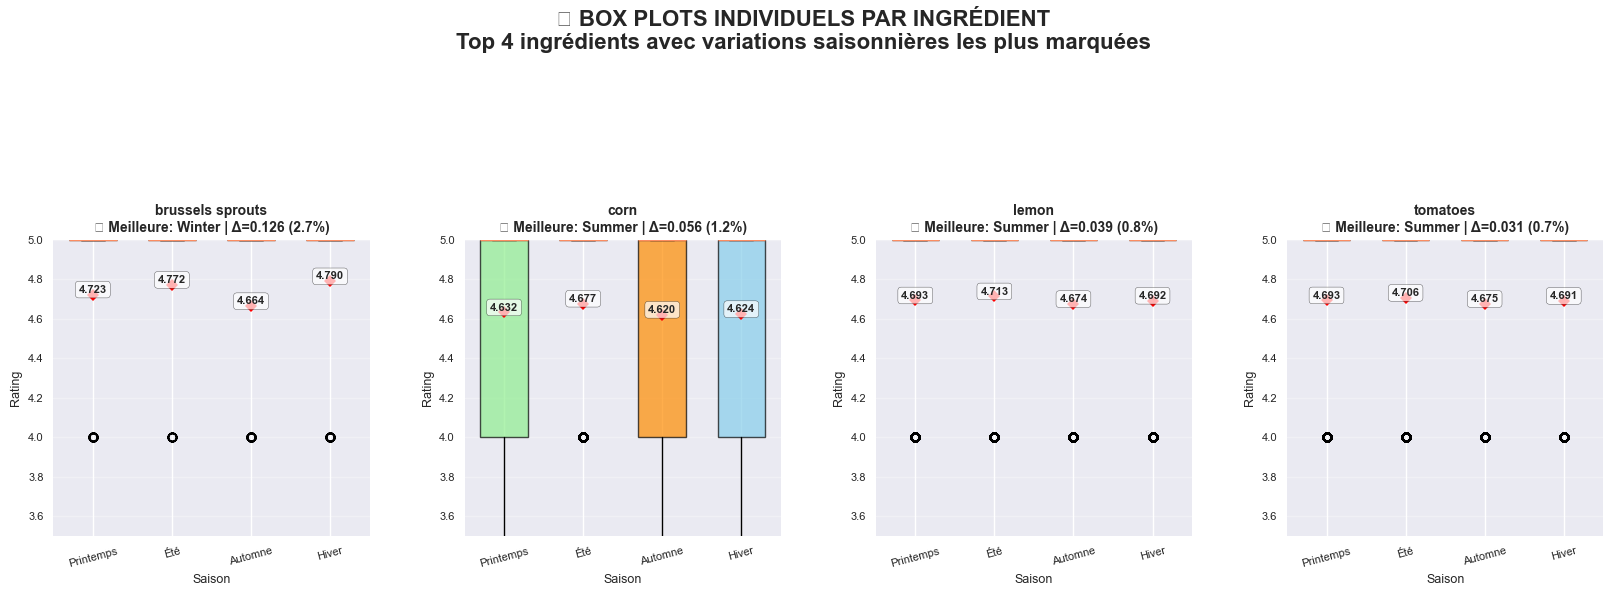

‚úÖ Box plots individuels cr√©√©s pour 4 ingr√©dients


In [10]:
# üì¶ BOX PLOTS INDIVIDUELS - GridSpec 4√ó4 pour Top 16 Ingr√©dients
print('üì¶ Cr√©ation des box plots individuels par ingr√©dient...')

if len(significant_seasonal) > 0:
    # S√©lection des top 16 ingr√©dients les plus variables
    top_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(16)['ingredient'].to_list()
    
    # Cr√©ation de la figure avec GridSpec 4√ó4
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)
    
    for idx, ingredient in enumerate(top_ingredients):
        row = idx // 4
        col = idx % 4
        ax = fig.add_subplot(gs[row, col])
        
        # Donn√©es pour cet ingr√©dient
        ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
        plot_data = ingredient_data.select(['season', 'rating']).to_pandas()
        
        # R√©cup√©ration des statistiques ANOVA
        ingredient_stats = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        
        # Box plot avec couleurs saisonni√®res
        seasons_ordered = ['Printemps', '√ât√©', 'Automne', 'Hiver']
        bp = ax.boxplot([plot_data[plot_data['season'] == s]['rating'].values 
                         for s in seasons_ordered if s in plot_data['season'].values],
                        labels=[s for s in seasons_ordered if s in plot_data['season'].values],
                        patch_artist=True,
                        widths=0.6,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=6))
        
        # Coloration des box plots
        for patch, season in zip(bp['boxes'], [s for s in seasons_ordered if s in plot_data['season'].values]):
            patch.set_facecolor(SEASON_COLORS.get(season, '#666666'))
            patch.set_alpha(0.7)
        
        # Ajout des moyennes saisonni√®res
        season_means = plot_data.groupby('season')['rating'].mean()
        for i, season in enumerate([s for s in seasons_ordered if s in plot_data['season'].values]):
            if season in season_means.index:
                mean_val = season_means[season]
                ax.text(i+1, mean_val, f'{mean_val:.3f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Identification de la meilleure saison avec emoji
        best_season = ingredient_stats['best_season']
        season_emojis = {'Printemps': 'üå±', '√ât√©': '‚òÄÔ∏è', 'Automne': 'üçÇ', 'Hiver': '‚ùÑÔ∏è'}
        best_emoji = season_emojis.get(best_season, 'üåø')
        
        # Calcul du % change total
        all_means = [ingredient_stats['spring_avg'], ingredient_stats['summer_avg'], 
                    ingredient_stats['autumn_avg'], ingredient_stats['winter_avg']]
        pct_change = (max(all_means) - min(all_means)) / min(all_means) * 100
        
        # Titre avec statistiques
        ax.set_title(f'{ingredient}\n{best_emoji} Meilleure: {best_season} | Œî={ingredient_stats["seasonal_range"]:.3f} ({pct_change:.1f}%)',
                    fontsize=10, fontweight='bold')
        ax.set_ylabel('Rating', fontsize=9)
        ax.set_xlabel('Saison', fontsize=9)
        ax.tick_params(axis='x', labelsize=8, rotation=15)
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(3.5, 5.0)
        
        # Annotation p-value si tr√®s significatif
        if ingredient_stats['p_value'] < 0.001:
            ax.text(0.95, 0.95, '***', transform=ax.transAxes,
                   fontsize=16, fontweight='bold', color='red',
                   ha='right', va='top')
    
    plt.suptitle('üì¶ BOX PLOTS INDIVIDUELS PAR INGR√âDIENT\n' +
                f'Top {len(top_ingredients)} ingr√©dients avec variations saisonni√®res les plus marqu√©es',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print(f'‚úÖ Box plots individuels cr√©√©s pour {len(top_ingredients)} ingr√©dients')
    
else:
    print('‚ö†Ô∏è  Aucune variation saisonni√®re significative pour box plots')